In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import StandardScaler
from ema_workbench import (Model, RealParameter, ScalarOutcome)
from ema_workbench import MultiprocessingEvaluator, ema_logging, load_results
from ema_workbench.analysis import prim, dimensional_stacking

In [3]:
experiments, outcomes = load_results('./data/exploratory_results_40000_zero_policy.tar.gz')

In [7]:
outcomes

{'A.1_Expected Annual Damage': array([[8.12787361e+07, 8.12787361e+07, 6.26669389e+07],
        [3.42189643e+08, 3.42189643e+08, 3.42189643e+08],
        [1.86185621e+08, 3.69718033e+08, 3.69718033e+08],
        ...,
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [6.10020960e+07, 6.10020960e+07, 7.65720817e+07]]),
 'A.1_Dike Investment Costs': array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]], dtype=int64),
 'A.1_Expected Number of Deaths': array([[0.04313546, 0.04313546, 0.04313546],
        [0.34118234, 0.34118234, 0.34118234],
        [0.18799799, 0.18799799, 0.18799799],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.05238894, 0.05238894, 0.05238894]]),
 'A.2_Expected Annual Damage': array([[1.26316091e+08, 1.26316091e+08, 9.73913122e+07],
        [0.00000000e+00,

In [5]:
experiments = pd.DataFrame(experiments)
outcomes = pd.DataFrame(outcomes)

ValueError: Per-column arrays must each be 1-dimensional

In [9]:
results = pd.concat([experiments, outcomes], axis = 1)

In [11]:
uncertainties = experiments.iloc[:, :19]
levers = experiments.iloc[:, 19:50]

In [13]:
X = uncertainties
y = outcomes['Expected Number of Deaths']

In [15]:
a = y.quantile(0.85)
Y = (y > a).astype(int).values

In [17]:
ema_logging.log_to_stderr(ema_logging.INFO)

prim_algorithm = prim.Prim(X, Y, threshold = 0.75)
box1 = prim_algorithm.find_box()

[MainProcess/INFO] 40000 points remaining, containing 6000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.08505, coverage: 0.567, density: 1.0 restricted_dimensions: 3


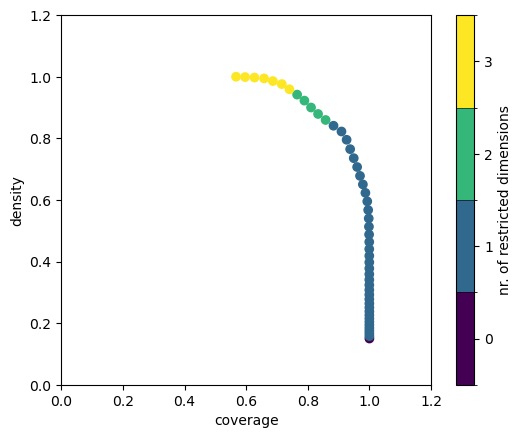

In [19]:
box1.show_tradeoff()
plt.show()

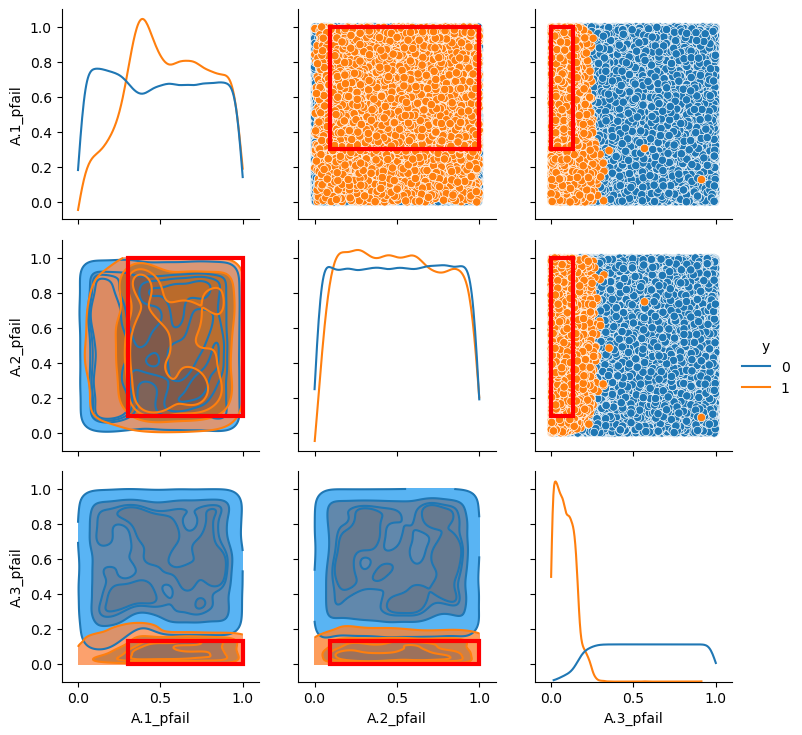

In [41]:
box1.show_pairs_scatter()
plt.show()

In [21]:
scenarios_of_interest = box1.peeling_trajectory
scenarios_of_interest = scenarios_of_interest[(scenarios_of_interest.coverage > 0.6) & (scenarios_of_interest.density > 0.8)]

The main focus of the client is to prevent casualties. Therefore it is important to have a high coverage as you don't want to miss scenario's with a high expected amount of casualties. It is less precise but more certain that all high casualty scenario's are captured in the box. Coverage above 0.9, therefore we loosen density restrictions to 0.5.

In [23]:
scenarios_of_interest = scenarios_of_interest.sort_values(by='density', ascending=False)
scenarios_of_interest

,coverage,density,id,k,mass,mean,n,res_dim
46,0.626833,0.997348,46,3761,0.094275,0.997348,3771,3
45,0.658000,0.994458,45,3948,0.099250,0.994458,3970,3
44,0.686667,0.985882,44,4120,0.104475,0.985882,4179,3
43,0.715667,0.976131,43,4294,0.109975,0.976131,4399,3
42,0.740333,0.959188,42,4442,0.115775,0.959188,4631,3
41,0.765333,0.941949,41,4592,0.121875,0.941949,4875,2
40,0.789000,0.922447,40,4734,0.128300,0.922447,5132,2
39,0.810500,0.900056,39,4863,0.135075,0.900056,5403,2
38,0.833333,0.879044,38,5000,0.142200,0.879044,5688,2
37,0.857833,0.859552,37,5147,0.149700,0.859552,5988,2


In [25]:
chosen_box = scenarios_of_interest[scenarios_of_interest['id'] == 39]
chosen_box_id = 39

In [27]:
limits = box1.box_lims[chosen_box_id]
limits

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
0,0,30.004800,"{1.0, 10.0, 1.5}",0.143089,30.004363,"{1.0, 10.0, 1.5}",0.000021,30.002791,"{1.5, 10.0, 1.0}",0.000003,30.002685,"{1.0, 10.0, 1.5}",0.000017,30.006070,"{1.0, 10.0, 1.5}",0.000004,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"
1,132,349.995374,"{1.0, 10.0, 1.5}",0.999989,349.998558,"{1.0, 10.0, 1.5}",0.999987,349.994674,"{1.5, 10.0, 1.0}",0.157598,349.993055,"{1.0, 10.0, 1.5}",0.999980,349.992859,"{1.0, 10.0, 1.5}",0.999981,"{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}","{1.5, 2.5, 3.5, 4.5}"


In [29]:
results_PRIM = results[
    (results['A.1_pfail'] >= limits['A.1_pfail'][0]) & (results['A.1_pfail'] <= limits['A.1_pfail'][1]) &
    (results['A.3_pfail'] >= limits['A.3_pfail'][0]) & (results['A.3_pfail'] <= limits['A.3_pfail'][1])
]

In [31]:
results_PRIM = results_PRIM.drop(columns=['policy', 'model'])
#results_box_numeric.to_csv('./data/prim_results_box.csv')

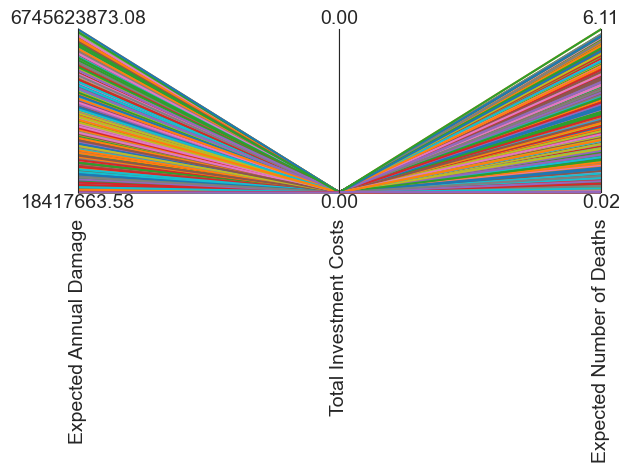

In [59]:
from ema_workbench.analysis import parcoords

data = pd.DataFrame({k:v for k,v in outcomes.items()})

indices = pd.concat([data.idxmax(), data.idxmin()]).unique()

limits = parcoords.get_limits(data)
axes = parcoords.ParallelAxes(limits)

axes.plot(data)
axes.plot(data.iloc[indices, :])
fig = plt.gcf()

plt.show()

In [61]:
print(data.idxmax())
print(data.idxmin())

Expected Annual Damage       21401
Total Investment Costs           0
Expected Number of Deaths    21441
dtype: int64
Expected Annual Damage       20800
Total Investment Costs           0
Expected Number of Deaths     4412
dtype: int64


In [33]:
selected_scenarios = experiments.loc[[21401, 21441, 20800, 4412]]
selected_scenarios = selected_scenarios.drop(columns=['policy', 'model'])

In [35]:
selected_scenarios

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,scenario
21401,100,90.896336,1.0,0.289866,100.419099,10.0,0.207468,271.628581,1.0,0.061121,...,0,0,0,0,0,0,0,0,0,21455
21441,126,187.420010,10.0,0.315649,43.622929,1.0,0.027066,57.687803,1.5,0.079734,...,0,0,0,0,0,0,0,0,0,21495
20800,79,63.688162,10.0,0.908738,170.092206,1.0,0.877065,246.939156,10.0,0.961088,...,0,0,0,0,0,0,0,0,0,20854
4412,11,189.906734,1.5,0.763564,186.512854,10.0,0.876666,89.003309,1.5,0.998555,...,0,0,0,0,0,0,0,0,0,4466


In [39]:
selected_scenarios = selected_scenarios.drop(columns=['0_RfR 0', '0_RfR 1', '0_RfR 2', '1_RfR 0',
       '1_RfR 1', '1_RfR 2', '2_RfR 0', '2_RfR 1', '2_RfR 2', '3_RfR 0',
       '3_RfR 1', '3_RfR 2', '4_RfR 0', '4_RfR 1', '4_RfR 2',
       'EWS_DaysToThreat', 'A.1_DikeIncrease 0', 'A.1_DikeIncrease 1',
       'A.1_DikeIncrease 2', 'A.2_DikeIncrease 0', 'A.2_DikeIncrease 1',
       'A.2_DikeIncrease 2', 'A.3_DikeIncrease 0', 'A.3_DikeIncrease 1',
       'A.3_DikeIncrease 2', 'A.4_DikeIncrease 0', 'A.4_DikeIncrease 1',
       'A.4_DikeIncrease 2', 'A.5_DikeIncrease 0', 'A.5_DikeIncrease 1',
       'A.5_DikeIncrease 2'])

In [5]:
selected_scenarios.to_csv('./data/Selected_Scenarios.csv', index=False)

NameError: name 'selected_scenarios' is not defined